In [1]:
%matplotlib inline
import numpy as np
import keras.backend as K
from keras import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Flatten
import copy

import Environment as E
import importlib
import matplotlib.pyplot as plt
import Heatmap as H
import GaussianTrashSource

Using TensorFlow backend.


## Parameters

In [2]:
# General

n_agents = 1

# Model

time_steps = 3
grid_size_w = 7
grid_size_h = 7
n_actions = 5

n_channels = time_steps + time_steps + 1
number_print = 1000
# Q-Learning

n_episodes = 10
n_steps = 250
epsilon = 0.75
epsilon_decay = 0.999
gamma = 0.9

# Policy Gradient

n_runs = 4
heatmap = H.Heatmap(keep_track_of_steps=1000)

## Model

## Policy Gradient

In [3]:
from Motion import Motion

def tuple_to_batch(known_data):
    batch = []
    for i,agent_pos in enumerate(known_data[2]):
        batch.append(np.concatenate((known_data[0],known_data[1],known_data[2][i:i+1])))
    batch = np.array(batch)
    return batch

def valid_move_mask(batch):
    mask = np.ones(shape=(n_agents, n_actions))
    indices = np.array(np.nonzero(batch[:, n_channels - 1, :, :])).T
    for idx in indices:
        agent, row, col = idx
        for action in range(n_actions):
            d_pos = Motion(action).value
            row += d_pos[0]
            col += d_pos[1]
            if row == -1 or row == grid_size_h or col == -1 or col == grid_size_w:
                mask[agent, action] = 0
    return mask
    

In [4]:
data_i = Input(shape=(n_channels, grid_size_w, grid_size_h))
conv_1 = Conv2D(16, (2, 2), activation="relu", data_format="channels_first")(data_i)
conv_2 = Conv2D(32, (2, 2), activation="relu", data_format="channels_first")(conv_1)
pool_1 = MaxPooling2D(data_format="channels_first")(conv_2)
drop_1 = Dropout(0.25)(pool_1)
flat_1 = Flatten()(drop_1)
feed_1 = Dense(64, activation="relu")(flat_1)
drop_2 = Dropout(0.25)(feed_1)
feed_2 = Dense(n_actions, activation="linear")(drop_2)
data_o = feed_2

model = Model(inputs=data_i, outputs=data_o)

### THE ONLY DIFFERENCE FROM Q-Learning loss=policy_loss
def policy_loss(yPred,reward_sums):
    return -K.dot(K.log(yPred + 1), reward_sums)

model.compile(optimizer="adam", loss=policy_loss)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 7, 7, 7)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 6, 6)          464       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 5, 5)          2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 2, 2)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 2, 2)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
__________

Trash Source 0 has its mean at [0, 2]
Trash Source 1 has its mean at [3, 4]
Episode 1 of 10
Current Random level is 0.74925
In Step 0 the average reward of 1000 is 0.0 
Actions: [0. 0. 0. 1. 0.]


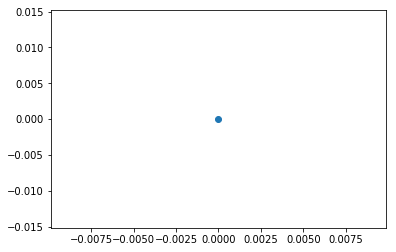

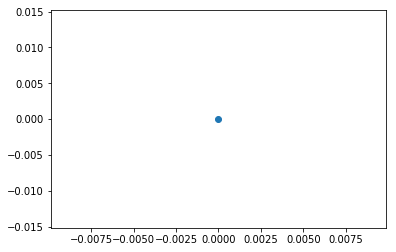

[[1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]
Current Random level is 0.7485007499999999
In Step 0 the average reward of 1000 is 0.0 
Actions: [  0.   0. 118.  64.  68.]


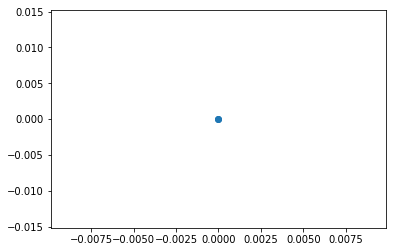

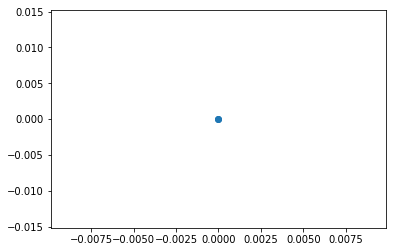

[[  1   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0]
 [240   0   0   0   0   0   0]]
Current Random level is 0.74775224925
In Step 0 the average reward of 1000 is 0.0 
Actions: [  0.   0. 131.  57.  62.]


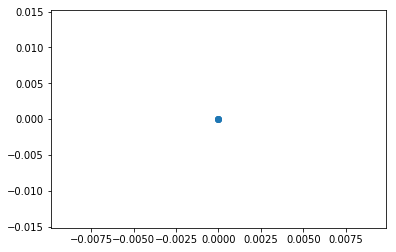

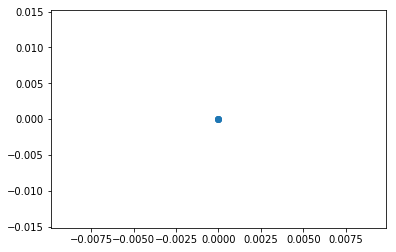

[[  1   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0]
 [490   0   0   0   0   0   0]]
Current Random level is 0.7470044970007499
In Step 0 the average reward of 1000 is 0.0 
Actions: [  0.   0. 137.  59.  54.]


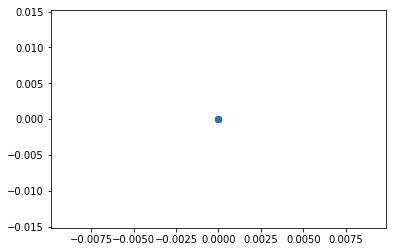

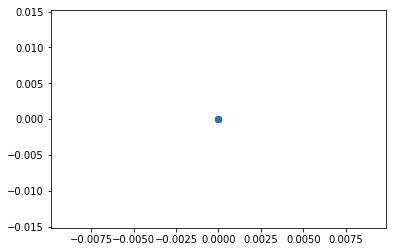

[[  1   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  2   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  1   0   0   0   0   0   0]
 [  4   0   0   0   0   0   0]
 [740   0   0   0   0   0   0]]
(1000, 7, 7, 7) (1000, 5)


InvalidArgumentError: Matrix size-incompatible: In[0]: [32,5], In[1]: [32,5]
	 [[{{node loss/dense_2_loss/MatMul}} = MatMul[T=DT_FLOAT, _class=["loc:@training/Adam/gradients/loss/dense_2_loss/MatMul_grad/MatMul_1"], transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:CPU:0"](loss/dense_2_loss/Log, dense_2/BiasAdd)]]

In [5]:
######NEEDS FIXING

for i in range(n_episodes):
    env = E.Environment(dim = (grid_size_h,grid_size_w),reward_eat_trash=10, 
                        reward_invalid_move=0, reward_nothing_happend=0, 
                        trash_appearence_prob=0.1, number_trash_sources=2, saved_timesteps=time_steps )
    _, _,  _, _, trash_sources = env.debug_data_export()
    for idx,trash_source in enumerate(trash_sources): 
        print("Trash Source {} has its mean at {}".format(idx, trash_source.mean))
    d = []
    action_avg = np.zeros((10000,5))
    list_avg_rwd = []
    list_steps = []
    all_time_reward = 0
    all_time_reward_avg_history = []
    all_time_reward_steps_history = []
    for k in range(n_agents):
        env.add_agent(coord=(k,0),capacity=100000)
    
    X = tuple_to_batch(env.export_known_data())
    
    P_vals = model.predict(X)
    
    if i % 10 == 0:
        print("Episode {} of {}".format(i + 1, n_episodes))

    r_sum = 0
    
    
    R = np.zeros((n_runs, n_steps, n_agents, n_actions))
    X_runs = np.zeros((n_runs, n_steps, n_agents, grid_size_w, grid_size_h, n_channels))

    for run in range(n_runs):
        action_history = np.zeros((n_steps, n_agents))
        for step in range(n_steps):

            mask = valid_move_mask(X)
            if np.random.random() < max(epsilon, 0.01):
                P_rand = np.random.random(n_agents * n_actions).reshape((n_agents, n_actions))
                actions = np.apply_along_axis(np.argmax, 1, P_rand * mask).tolist()
            else:
                actions = np.apply_along_axis(np.argmax, 1, P_vals * mask).tolist()

            # new known state and rewards
            X_reward = env.move_agents(actions)
            heatmap.add_map(X_reward[1][-1]) #Get the current position of all agents
            # after all agents move
            X_new = tuple_to_batch(X_reward[:3])
            rewards = X_reward[3]

            all_time_reward += sum(rewards)
            action_avg[step%number_print, : ] = 0
            action_avg[step%number_print,actions[0]]= 1
            d.append(sum(rewards))
            while(len(d)>number_print):
                del(d[0])
            if(step% number_print == 0): 
                mean = sum(d) / number_print

                epsilon *= epsilon_decay
                print("Current Random level is {}".format(max(epsilon, 0.01)))
                print("In Step {} the average reward of {} is {} ".format(step, number_print,mean))
                print("Actions: {}".format(np.sum(action_avg, axis = 0)))
                list_avg_rwd.append(mean)
                list_steps.append(step)

                plt.scatter(list_steps, list_avg_rwd)
                plt.show()


                all_time_reward_avg = all_time_reward / (step+1)
                all_time_reward_avg_history.append(all_time_reward_avg)
                all_time_reward_steps_history.append(step)
                plt.scatter(all_time_reward_steps_history, all_time_reward_avg_history)
                plt.show()


                #Heatmap
                print(heatmap.get_heatmap())
                #heatmap.show_heatmap()


            for agent_i in range(n_agents):
                action_history[step,agent_i] = int(actions[agent_i])
                X_runs[run,step,agent_i] = copy.copy(X[agent_i])
                R[run, step, agent_i, actions[agent_i]] = rewards[agent_i]
                #update previous rewards in R matrix:
                for i,prev in enumerate(range(step-25,step).__reversed__()):
                    R[run, prev, agent_i, int(action_history[prev,agent_i])] += rewards[agent_i] * gamma ** i

    #epochs may be changed
    X_fit = X_runs.reshape((n_runs * n_steps * n_agents, grid_size_w, grid_size_h, n_channels))
    R_fit = R.reshape((n_runs * n_steps * n_agents, n_actions))
    print(X_fit.shape, R_fit.shape)
    model.fit(X_fit, R_fit, epochs=1, verbose=0)